# Development notebook: Tests for QuTiP's stochastic Schrödinger equation solver

Copyright (C) 2011 and later, Paul D. Nation & Robert J. Johansson

In this notebook we test the qutip stochastic Schrödinger equation solver (ssesolve) with a few examples. The same examples are solved using the stochastic master equation solver in the notebook development-smesolve-tests.

<style>
.rendered_html {
    font-family: Liberation Serif;
}

.rendered_html h1 {
    font-family: Liberation Sans;
    margin: 0 0;
}

.rendered_html h2 {
    font-family: Liberation Sans;
    margin: 0 0;
}
</style>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from qutip import *
import numpy as np

## Photo-count detection

### Theory

Stochastic Schrödinger equation for photocurrent detection, in Milburn's formulation, is

$$
d|\psi(t)\rangle = -iH|\psi(t)\rangle dt + \left(\frac{a}{\sqrt{\langle a^\dagger a \rangle_\psi(t)}} - 1\right) |\psi(t)\rangle dN(t) - \frac{1}{2}\gamma\left(\langle a^\dagger a \rangle_\psi(t) - a^\dagger a \right) |\psi(t)\rangle dt
$$

and $dN(t)$ is a Poisson distributed increment with $E[dN(t)] = \gamma \langle a^\dagger a\rangle (t)$.

### Formulation in QuTiP

In QuTiP we write the stochastic Schrödinger equation on the form:

$$
d|\psi(t)\rangle = -iH|\psi(t)\rangle dt + D_{1}[c] |\psi(t)\rangle dt  + D_{2}[c] |\psi(t)\rangle dW
$$

where $c = \sqrt{\gamma} a$ is the collapse operator including the rate of the process as a coefficient in the operator. We can identify

$$
D_{1}[c] |\psi(t)\rangle = - \frac{1}{2}\left(\langle c^\dagger c \rangle_\psi(t) - c^\dagger c \right)
$$

$$
D_{2}[c] |\psi(t)\rangle = \frac{c}{\sqrt{\langle c^\dagger c \rangle_\psi(t)}} - 1
$$

$$dW = dN(t)$$

### Reference solution: deterministic master equation

In [3]:
N = 10
w0 = 0.5 * 2 * np.pi
times = np.linspace(0, 15, 150)
dt = times[1] - times[0]
gamma = 0.25
A = 2.5
ntraj = 50
nsubsteps = 100

In [4]:
a = destroy(N)
x = a + a.dag()

In [5]:
H = w0 * a.dag() * a

In [6]:
psi0 = fock(N, 5)

In [7]:
sc_ops = [np.sqrt(gamma) * a]

In [8]:
e_ops = [a.dag() * a, a + a.dag(), (-1j)*(a - a.dag())]

In [9]:
result_ref = mesolve(H, psi0, times, sc_ops, e_ops)

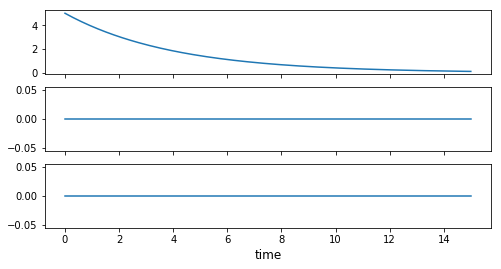

In [10]:
plot_expectation_values(result_ref);

### Solve using stochastic master equation

$\displaystyle D_{1}[a, |\psi\rangle] = 
\frac{1}{2} ( \langle \psi|a^\dagger a |\psi\rangle  - a^\dagger a )|\psi\rangle
$


$\displaystyle D_{2}[a, |\psi\rangle] = 
\frac{a|\psi\rangle}{\sqrt{\langle \psi| a^\dagger a|\psi\rangle}} - |\psi\rangle
$

## Using QuTiP built-in photo-current detection functions for $D_1$ and $D_2$

In [11]:
result = photocurrentsesolve(H, psi0, times, sc_ops, e_ops,
                  ntraj=ntraj*5, nsubsteps=nsubsteps, store_measurement=True, normalize=0)

10.0%. Run time:   7.63s. Est. time left: 00:00:01:08
20.0%. Run time:  14.84s. Est. time left: 00:00:00:59
30.0%. Run time:  20.81s. Est. time left: 00:00:00:48
40.0%. Run time:  26.04s. Est. time left: 00:00:00:39
50.0%. Run time:  35.50s. Est. time left: 00:00:00:35
60.0%. Run time:  40.78s. Est. time left: 00:00:00:27
70.0%. Run time:  45.92s. Est. time left: 00:00:00:19
80.0%. Run time:  51.42s. Est. time left: 00:00:00:12
90.0%. Run time:  57.04s. Est. time left: 00:00:00:06
Total run time:  61.93s


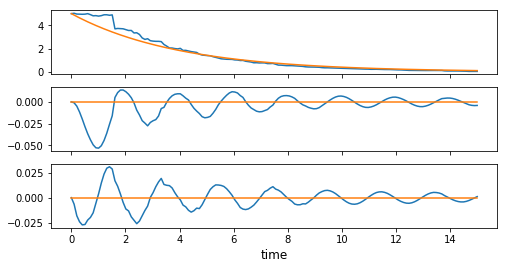

In [12]:
plot_expectation_values([result, result_ref]);

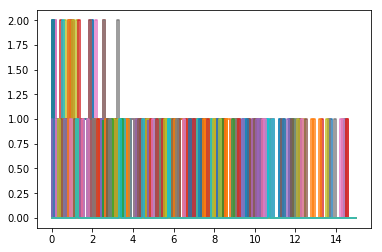

In [13]:
for m in result.measurement:
    plt.step(times, dt * m.real)

# Homodyne detection

In [14]:
ntraj = 50
nsubsteps = 200

In [15]:
H = w0 * a.dag() * a + A * (a + a.dag())

In [16]:
result_ref = mesolve(H, psi0, times, sc_ops, e_ops)

## Theory

Stochastic master equation for homodyne can be written as (see Gardiner and Zoller, Quantum Noise)

$$
d|\psi(t)\rangle = -iH|\psi(t)\rangle dt + 
\frac{1}{2}\gamma \left(
\langle a + a^\dagger \rangle_\psi a  - a^\dagger a   - \frac{1}{4}\langle a + a^\dagger \rangle_\psi^2  \right)|\psi(t)\rangle dt  
+ 
\sqrt{\gamma}\left(
a - \frac{1}{2} \langle a + a^\dagger \rangle_\psi  
\right)|\psi(t)\rangle dW
$$

where $dW(t)$ is a normal distributed increment with $E[dW(t)] = \sqrt{dt}$.

In QuTiP format we have:

$$
d|\psi(t)\rangle = -iH|\psi(t)\rangle dt + D_{1}[c, |\psi(t)\rangle] dt  + D_{2}[c, |\psi(t)\rangle] dW
$$

where $c = \sqrt{\gamma} a$, so we can identify

$$
D_{1}[c, |\psi\rangle] = 
\frac{1}{2}\left(
\langle c + c^\dagger \rangle_\psi c   - c^\dagger c  - \frac{1}{4}\langle c + c^\dagger \rangle_\psi^2 
\right) |\psi(t)\rangle 
$$

In [17]:
op = sc_ops[0]
opp = (op + op.dag()).data
opn = (op.dag()*op).data
op = op.data
Hd = H.data * -1j
def d1_psi_func(t, psi):
    e_x = cy.cy_expect_psi(opp, psi, 0)
    return  cy.spmv(Hd, psi) + 0.5 * (e_x * cy.spmv(op, psi) - cy.spmv(opn, psi) - 0.25 * e_x ** 2 * psi)

$$
D_{2}[c,|\psi\rangle] = 
\left(c  - \frac{1}{2} \langle c + c^\dagger \rangle_\psi \right)|\psi(t)\rangle  
$$

In [18]:
def d2_psi_func(t, psi):
    out = np.zeros((1,len(psi)), dtype=complex)
    e_x = cy.cy_expect_psi(opp, psi, 0)
    out[0,:] = cy.spmv(op,psi)
    out -= 0.5 * e_x * psi
    return out

In [19]:
result = general_stochastic(psi0, times, d1=d1_psi_func, d2=d2_psi_func, 
                            e_ops=e_ops, ntraj=ntraj, 
                            m_ops=[a + a.dag()], dW_factors=[1/np.sqrt(gamma)],
                            nsubsteps=nsubsteps, store_measurement=True)

10.0%. Run time:  11.13s. Est. time left: 00:00:01:40
20.0%. Run time:  22.08s. Est. time left: 00:00:01:28
30.0%. Run time:  34.41s. Est. time left: 00:00:01:20
40.0%. Run time:  45.41s. Est. time left: 00:00:01:08
50.0%. Run time:  57.50s. Est. time left: 00:00:00:57
60.0%. Run time:  69.12s. Est. time left: 00:00:00:46
70.0%. Run time:  80.72s. Est. time left: 00:00:00:34
80.0%. Run time:  91.96s. Est. time left: 00:00:00:22
90.0%. Run time: 104.51s. Est. time left: 00:00:00:11
Total run time: 115.80s


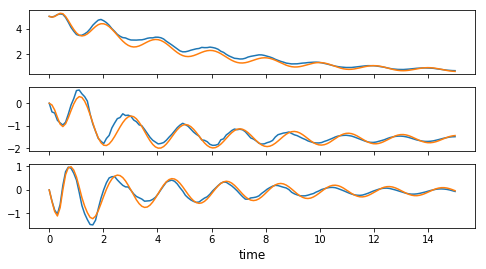

In [20]:
plot_expectation_values([result, result_ref]);

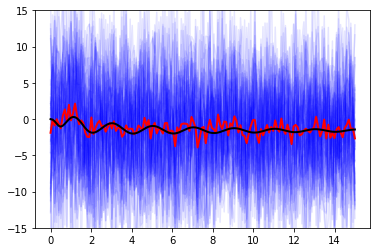

In [21]:
for m in result.measurement:
    plt.plot(times, m[:, 0].real, 'b', alpha=0.1)

plt.plot(times,  np.array(result.measurement).mean(axis=0)[:,0].real, 'r', lw=2)
    
plt.plot(times, result_ref.expect[1], 'k', lw=2)
plt.ylim(-15, 15);

### Solve problem again, this time with a specified noise (from previous run)

In [22]:
result = general_stochastic(psi0, times, d1=d1_psi_func, d2=d2_psi_func, 
                            e_ops=e_ops, ntraj=ntraj, noise=result.noise,
                            m_ops=[a + a.dag()], dW_factors=[1/np.sqrt(gamma)],
                            nsubsteps=nsubsteps, store_measurement=True)

10.0%. Run time:  11.43s. Est. time left: 00:00:01:42
20.0%. Run time:  22.58s. Est. time left: 00:00:01:30
30.0%. Run time:  33.85s. Est. time left: 00:00:01:18
40.0%. Run time:  45.30s. Est. time left: 00:00:01:07
50.0%. Run time:  57.00s. Est. time left: 00:00:00:56
60.0%. Run time:  69.91s. Est. time left: 00:00:00:46
70.0%. Run time:  81.48s. Est. time left: 00:00:00:34
80.0%. Run time:  93.83s. Est. time left: 00:00:00:23
90.0%. Run time: 104.88s. Est. time left: 00:00:00:11
Total run time: 116.29s


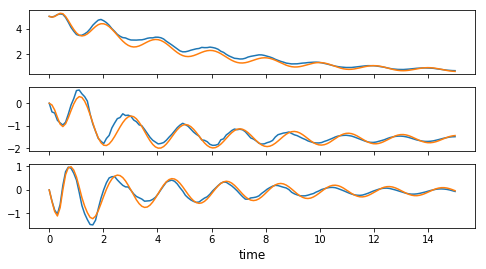

In [23]:
plot_expectation_values([result, result_ref]);

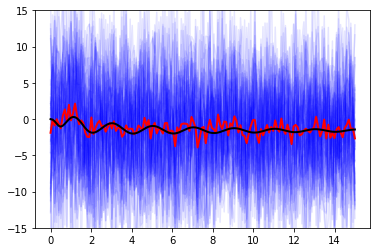

In [24]:
for m in result.measurement:
    plt.plot(times, m[:, 0].real, 'b', alpha=0.1)

plt.plot(times,  np.array(result.measurement).mean(axis=0)[:,0].real, 'r', lw=2)
    
plt.plot(times, result_ref.expect[1], 'k', lw=2)
plt.ylim(-15, 15);

## Using QuTiP built-in homodyne detection functions for $D_1$ and $D_2$

In [25]:
result = ssesolve(H, psi0, times, sc_ops, e_ops, ntraj=ntraj, nsubsteps=nsubsteps,
                  method='homodyne', store_measurement=True, dW_factors=[1])

10.0%. Run time:  22.28s. Est. time left: 00:00:03:20
20.0%. Run time:  40.93s. Est. time left: 00:00:02:43
30.0%. Run time:  62.53s. Est. time left: 00:00:02:25
40.0%. Run time:  84.26s. Est. time left: 00:00:02:06
50.0%. Run time: 104.84s. Est. time left: 00:00:01:44
60.0%. Run time: 127.63s. Est. time left: 00:00:01:25
70.0%. Run time: 170.99s. Est. time left: 00:00:01:13
80.0%. Run time: 209.55s. Est. time left: 00:00:00:52
90.0%. Run time: 247.66s. Est. time left: 00:00:00:27
Total run time: 284.57s


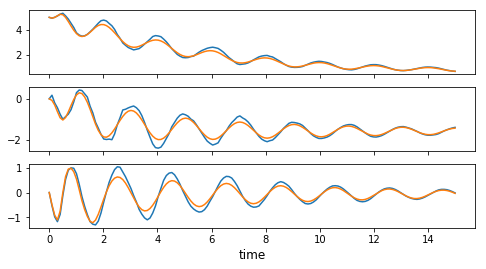

In [26]:
plot_expectation_values([result, result_ref]);

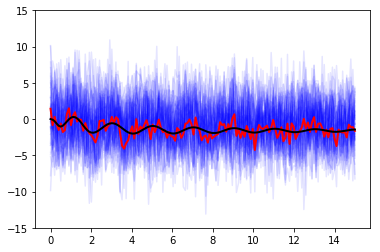

In [27]:
for m in result.measurement:
    plt.plot(times, m[:, 0].real, 'b', alpha=0.1)

plt.plot(times,  np.array(result.measurement).mean(axis=0)[:,0].real/np.sqrt(gamma), 'r', lw=2)
    
plt.plot(times, result_ref.expect[1], 'k', lw=2)
plt.ylim(-15, 15);

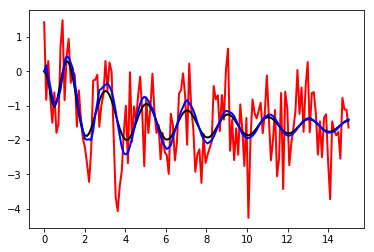

In [28]:
plt.plot(times,  np.array(result.measurement).mean(axis=0)[:,0].real/np.sqrt(gamma), 'r', lw=2)
plt.plot(times, result_ref.expect[1], 'k', lw=2)
plt.plot(times, result.expect[1], 'b', lw=2)

#### Solve problem again, this time with a specified noise (from previous run)

In [29]:
result = ssesolve(H, psi0, times, sc_ops, e_ops, ntraj=ntraj, nsubsteps=nsubsteps,
                  method='homodyne', store_measurement=True, noise=result.noise)

10.0%. Run time:  40.29s. Est. time left: 00:00:06:02
20.0%. Run time:  76.23s. Est. time left: 00:00:05:04
30.0%. Run time: 108.64s. Est. time left: 00:00:04:13
40.0%. Run time: 142.13s. Est. time left: 00:00:03:33
50.0%. Run time: 189.00s. Est. time left: 00:00:03:08
60.0%. Run time: 240.22s. Est. time left: 00:00:02:40
70.0%. Run time: 281.10s. Est. time left: 00:00:02:00
80.0%. Run time: 329.55s. Est. time left: 00:00:01:22
90.0%. Run time: 374.20s. Est. time left: 00:00:00:41
Total run time: 414.39s


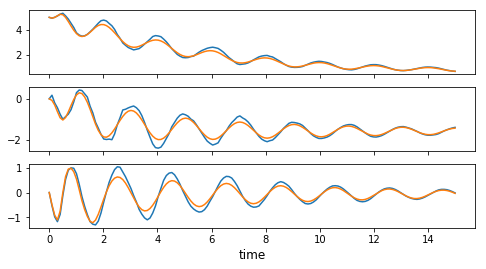

In [30]:
plot_expectation_values([result, result_ref]);

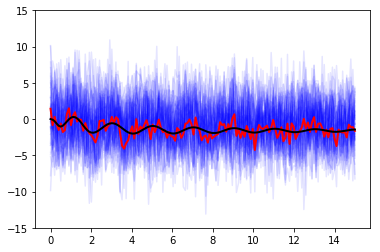

In [31]:
for m in result.measurement:
    plt.plot(times, m[:, 0].real, 'b', alpha=0.1)

plt.plot(times,  np.array(result.measurement).mean(axis=0)[:,0].real/np.sqrt(gamma), 'r', lw=2)
    
plt.plot(times, result_ref.expect[1], 'k', lw=2)
plt.ylim(-15, 15);

# Heterodyne detection

Stochastic Schrödinger equation for heterodyne detection can be written as

$$
d|\psi(t)\rangle = -iH|\psi(t)\rangle dt 
-\frac{1}{2}\gamma\left(a^\dagger a - \langle a^\dagger \rangle a +  \frac{1}{2}\langle a \rangle\langle a^\dagger \rangle)\right)|\psi(t)\rangle dt
+ 
\sqrt{\gamma/2}\left(
a - \frac{1}{2} \langle a + a^\dagger \rangle_\psi  
\right)|\psi(t)\rangle dW_1
-i
\sqrt{\gamma/2}\left(
a - \frac{1}{2} \langle a - a^\dagger \rangle_\psi  
\right)|\psi(t)\rangle dW_2
$$

where $dW_i(t)$ is a normal distributed increment with $E[dW_i(t)] = \sqrt{dt}$.

In QuTiP format we have:

$$
d|\psi(t)\rangle = -iH|\psi(t)\rangle dt + D_{1}[c, |\psi(t)\rangle] dt  + \sum_n D_{2}^{(n)}[c, |\psi(t)\rangle] dW_n
$$

where $c = \sqrt{\gamma} a$, so we can identify

$$
D_1[c, |\psi(t)\rangle] =
-\frac{1}{2}\left(c^\dagger c - \langle c^\dagger \rangle c +  \frac{1}{2}\langle c \rangle\langle c^\dagger \rangle \right) |\psi(t)\rangle
$$

In [32]:
op = sc_ops[0]
opd = (op.dag()).data
opp = (op + op.dag()).data
opm = (op + op.dag()).data
opn = (op.dag()*op).data
op = op.data
Hd = H.data * -1j
def d1_psi_func(t, psi):
    e_xd = cy.cy_expect_psi(opd, psi, 0)
    e_x = cy.cy_expect_psi(op, psi, 0)
    return  cy.spmv(Hd, psi) - 0.5 * (cy.spmv(opn, psi) - e_xd * cy.spmv(op, psi) + 0.5 * e_x * e_xd * psi)


$$D_{2}^{(1)}[c, |\psi(t)\rangle] = \sqrt{1/2} (c - \langle c + c^\dagger \rangle / 2) \psi$$

$$D_{2}^{(1)}[c, |\psi(t)\rangle] = -i\sqrt{1/2} (c - \langle c - c^\dagger \rangle /2) \psi$$

In [33]:
sqrt2 = np.sqrt(0.5)
def d2_psi_func(t, psi):
    out = np.zeros((2,len(psi)), dtype=complex)
    e_p = cy.cy_expect_psi(opp, psi, 0)
    e_m = cy.cy_expect_psi(opm, psi, 0)
    out[0,:] = (cy.spmv(op,psi) - e_p * 0.5 * psi)*sqrt2
    out[1,:] = (cy.spmv(op,psi) - e_m * 0.5 * psi)*sqrt2*-1j
    return out


In [34]:
result = general_stochastic(psi0, times, d1=d1_psi_func, d2=d2_psi_func, 
                            e_ops=e_ops, ntraj=ntraj, len_d2=2,
                            m_ops=[(a + a.dag()), (-1j)*(a - a.dag())], dW_factors=[2/np.sqrt(gamma), 2/np.sqrt(gamma)],
                            nsubsteps=nsubsteps, store_measurement=True)

10.0%. Run time:  38.27s. Est. time left: 00:00:05:44
20.0%. Run time:  78.72s. Est. time left: 00:00:05:14
30.0%. Run time: 111.22s. Est. time left: 00:00:04:19
40.0%. Run time: 146.36s. Est. time left: 00:00:03:39
50.0%. Run time: 177.61s. Est. time left: 00:00:02:57
60.0%. Run time: 211.91s. Est. time left: 00:00:02:21
70.0%. Run time: 244.76s. Est. time left: 00:00:01:44
80.0%. Run time: 277.73s. Est. time left: 00:00:01:09
90.0%. Run time: 310.84s. Est. time left: 00:00:00:34
Total run time: 344.61s


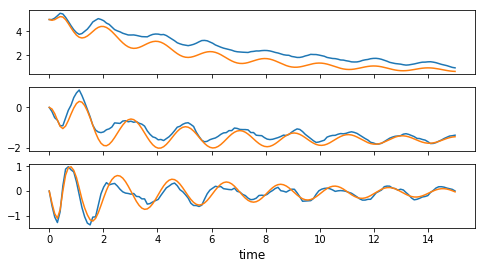

In [35]:
plot_expectation_values([result, result_ref]);

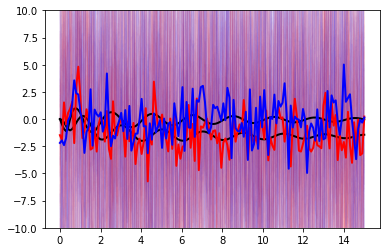

In [36]:
#fig, ax = subplots()

for m in result.measurement:
    plt.plot(times, m[:, 0].real, 'r', alpha=0.025)
    plt.plot(times, m[:, 1].real, 'b', alpha=0.025)
    
plt.plot(times, result_ref.expect[1], 'k', lw=2);
plt.plot(times, result_ref.expect[2], 'k', lw=2);
plt.ylim(-10, 10)

plt.plot(times, np.array(result.measurement).mean(axis=0)[:,0].real, 'r', lw=2);
plt.plot(times, np.array(result.measurement).mean(axis=0)[:,1].real, 'b', lw=2);

## Using QuTiP built-in heterodyne detection functions for $D_1$ and $D_2$

In [37]:
result = ssesolve(H, psi0, times, sc_ops, e_ops, ntraj=ntraj, nsubsteps=nsubsteps,
                  method='heterodyne', store_measurement=True)

10.0%. Run time: 100.11s. Est. time left: 00:00:15:00
20.0%. Run time: 221.09s. Est. time left: 00:00:14:44
30.0%. Run time: 357.20s. Est. time left: 00:00:13:53
40.0%. Run time: 484.58s. Est. time left: 00:00:12:06
50.0%. Run time: 604.73s. Est. time left: 00:00:10:04
60.0%. Run time: 713.16s. Est. time left: 00:00:07:55
70.0%. Run time: 847.55s. Est. time left: 00:00:06:03
80.0%. Run time: 965.59s. Est. time left: 00:00:04:01
90.0%. Run time: 1095.71s. Est. time left: 00:00:02:01
Total run time: 1215.40s


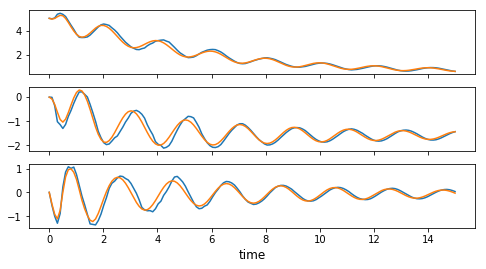

In [38]:
plot_expectation_values([result, result_ref]);

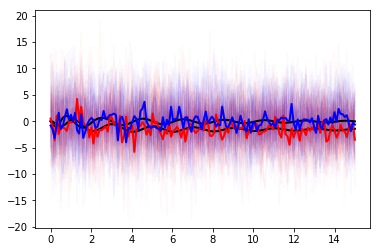

In [39]:
for m in result.measurement:
    plt.plot(times, m[:, 0, 0].real, 'r', alpha=0.025)
    plt.plot(times, m[:, 0, 1].real, 'b', alpha=0.025)
    
plt.plot(times, result_ref.expect[1], 'k', lw=2)
plt.plot(times, result_ref.expect[2], 'k', lw=2)

plt.plot(times, np.array(result.measurement).mean(axis=0)[:,0,0].real/np.sqrt(gamma), 'r', lw=2)
plt.plot(times, np.array(result.measurement).mean(axis=0)[:,0,1].real/np.sqrt(gamma), 'b', lw=2)

### Solve problem again, this time with a specified noise (from previous run)

In [40]:
result = ssesolve(H, psi0, times, sc_ops, e_ops, ntraj=ntraj, nsubsteps=nsubsteps,
                  method='heterodyne', store_measurement=True, noise=result.noise)

10.0%. Run time: 103.96s. Est. time left: 00:00:15:35
20.0%. Run time: 149.44s. Est. time left: 00:00:09:57
30.0%. Run time: 197.21s. Est. time left: 00:00:07:40
40.0%. Run time: 245.02s. Est. time left: 00:00:06:07
50.0%. Run time: 291.29s. Est. time left: 00:00:04:51
60.0%. Run time: 338.67s. Est. time left: 00:00:03:45
70.0%. Run time: 386.45s. Est. time left: 00:00:02:45
80.0%. Run time: 432.21s. Est. time left: 00:00:01:48
90.0%. Run time: 477.93s. Est. time left: 00:00:00:53
Total run time: 524.99s


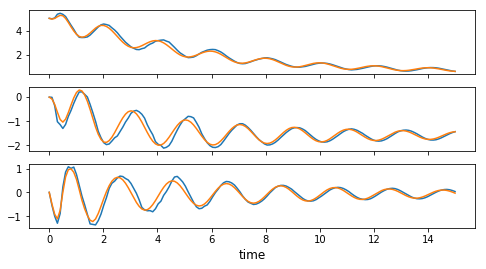

In [41]:
plot_expectation_values([result, result_ref]);

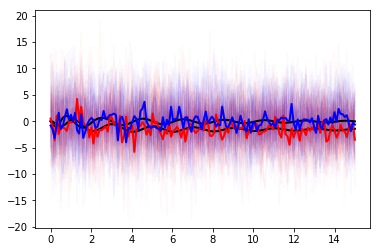

In [42]:
for m in result.measurement:
    plt.plot(times, m[:, 0, 0].real, 'r', alpha=0.025)
    plt.plot(times, m[:, 0, 1].real, 'b', alpha=0.025)
    
plt.plot(times, result_ref.expect[1], 'k', lw=2);
plt.plot(times, result_ref.expect[2], 'k', lw=2);

plt.plot(times, np.array(result.measurement).mean(axis=0)[:,0,0].real/np.sqrt(gamma), 'r', lw=2);
plt.plot(times, np.array(result.measurement).mean(axis=0)[:,0,1].real/np.sqrt(gamma), 'b', lw=2);

# Software version

In [43]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.4.0.dev0+1cf1dd3e
Numpy,1.16.0
SciPy,1.2.0
matplotlib,3.0.2
Cython,0.29.2
Number of CPUs,2
BLAS Info,OPENBLAS
IPython,7.2.0
Python,"3.6.7 (default, Oct 22 2018, 11:32:17) [GCC 8.2.0]"
OS,posix [linux]
